<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/non_linear_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('ggplot')

In [0]:
t = np.linspace(0, 1, 501)
t_rand = t[np.random.permutation(t.shape[0])]
s_1 = 0.1*t
s_2 = -0.5*t+0.2

x_1 = 0.3*s_1+0.4*s_2
x_2 = -0.3*s_1+0.9*s_2
#x_3 = 0.4*s_1

x_1 = np.reshape(x_1, [-1,1])
x_2 = np.reshape(x_2, [-1,1])
#x_3 = np.reshape(x_3, [-1,1])

x = np.concatenate((x_1, x_2), axis=1)

x_true = np.concatenate((x, np.reshape(t, [-1,1])), axis=1)
c_true = 1+np.zeros([x_true.shape[0],1], np.int32)
x_false = np.concatenate((x, np.reshape(t_rand, [-1,1])), axis=1)
c_false = np.zeros([x_true.shape[0],1], np.int32)

features = np.concatenate((x_true, x_false), axis=0)
labels = np.concatenate((c_true, c_false), axis=0)

In [0]:
#Reset the graph 
tf.reset_default_graph()

#Parameters
learning_rate = 0.001
batch_size = 10
n_epochs = 500

#Create placeholders
X = tf.placeholder(tf.float32, shape=[None, 3], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 1], name='Y')
LEARNING_RATE = tf.placeholder(tf.float32, shape=[], name='LEARNING_RATE')
#Create variables



h = tf.layers.dense(X[:,0:-1], 2, tf.nn.leaky_relu)
h = tf.layers.dense(h, 2, tf.nn.leaky_relu)
z = tf.layers.dense(h, 2, tf.nn.leaky_relu)

k1 = tf.concat([tf.reshape(z[:,0],[-1,1]), tf.reshape(X[:,-1], [-1,1])], axis=1)
k1 = tf.layers.dense(k1,8, tf.nn.relu)
k1 = tf.layers.dense(k1,8, tf.nn.relu)
k1 = tf.layers.dense(k1,8, tf.nn.relu)
k1 = tf.layers.dense(k1,1)

k2 = tf.concat([tf.reshape(z[:,1],[-1,1]), tf.reshape(X[:,-1], [-1,1])], axis=1)
k2 = tf.layers.dense(k2,8, tf.nn.relu)
k2 = tf.layers.dense(k2,8, tf.nn.relu)
k2 = tf.layers.dense(k2,8, tf.nn.relu)
k2 = tf.layers.dense(k2,1)

k = k1+k2


cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=k)


loss = tf.reduce_mean(cross_entropy)

#Define an optimizer
optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)


predicted = tf.nn.sigmoid(k)
correct_pred = tf.equal(tf.round(predicted), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [0]:
def batch_generator(features, labels, batch_size):
  """Function to create python generator to shuffle and split features and labels into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part], labels[part]

In [148]:
#Create a TF session:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    gen = batch_generator(features, labels, batch_size) #create batch generator
    total_loss = 0
    total_acc = 0
    for j in range(np.int(x.shape[0]/batch_size)):
      x_batch, y_batch = gen.__next__()
      _, batch_loss, batch_acc = sess.run([optimizer, loss, accuracy], feed_dict={X: x_batch, Y: y_batch, LEARNING_RATE: learning_rate})
      total_loss += batch_loss
      total_acc += batch_acc
    if (i+1)% 10 == 0 or i == 0:
      print('Epoch: {0}, Loss: {1}, Batch_acc: {2}'.format((i+1), total_loss, total_acc))
  latent = sess.run([z], feed_dict= {X: features})

Epoch: 1, Loss: 35.12101572751999, Batch_acc: 26.200000278651714
Epoch: 10, Loss: 31.136705577373505, Batch_acc: 33.100000351667404
Epoch: 20, Loss: 17.52789343893528, Batch_acc: 44.29999974370003
Epoch: 30, Loss: 11.940576933324337, Batch_acc: 46.09999966621399
Epoch: 40, Loss: 11.696612935513258, Batch_acc: 45.89999961853027
Epoch: 50, Loss: 7.513543467968702, Batch_acc: 47.49999958276749
Epoch: 60, Loss: 6.517838163301349, Batch_acc: 47.69999974966049
Epoch: 70, Loss: 7.084107633680105, Batch_acc: 47.599999606609344
Epoch: 80, Loss: 6.744522077962756, Batch_acc: 47.799999713897705
Epoch: 90, Loss: 5.697542718611658, Batch_acc: 48.09999966621399
Epoch: 100, Loss: 5.731789702549577, Batch_acc: 47.999999701976776
Epoch: 110, Loss: 5.949953834526241, Batch_acc: 47.79999965429306
Epoch: 120, Loss: 5.2890699207782745, Batch_acc: 48.29999977350235
Epoch: 130, Loss: 3.80064694955945, Batch_acc: 48.89999979734421
Epoch: 140, Loss: 5.403296328149736, Batch_acc: 48.19999969005585
Epoch: 150, L

In [0]:
latent_ = np.squeeze(np.asarray(latent))


In [150]:
latent_.shape

(1002, 2)

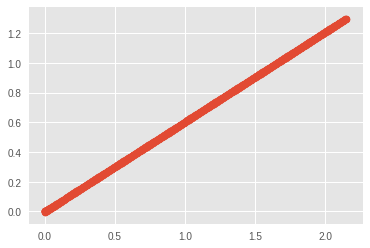

In [151]:
plt.scatter(latent_[0:501,0], latent_[0:501,1])

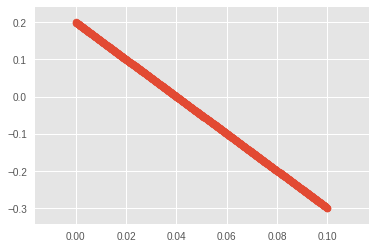

In [152]:
plt.scatter(s_1, s_2)